In [ ]:
# plot cells and extract ephys features using ipfx

In [1]:
import pyabf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

In [2]:
from scripts.util_functions import guess_response_gain, get_stim_gain, get_stim_info, get_stim_dict

In [3]:
# read final csv that has the ouput of metadata gathering process
csv_meta_save_path = 'output_files/cell_final_raw_meta_df.csv'
cell_final_raw_meta_df = pd.read_csv(open(csv_meta_save_path, 'rb'))  

In [4]:
from ipfx.sweep import Sweep, SweepSet

def cell_id_to_sweep_set(abf_file_name, meta_info_df = cell_final_raw_meta_df):
    
    curr_file = abf_file_name

    meta_dict = meta_info_df

    #curr_file = '15o08020.abf'

    meta_row = meta_dict.loc[meta_dict['cell_id'] == curr_file]

    file_path = meta_row['full_path'].values[0]
    stim_file_path = meta_row['stim_path'].values[0]


    resp_abf = pyabf.ABF(file_path)
    stim_abf = pyabf.ABF(stim_file_path) # for some files we're using stim traces from a different file

    num_sweeps = int(meta_row['num_sweeps'].values[0])
    stim_channel_num = int(meta_row['stim_chan'].values[0])
    response_chan_num = int(meta_row['resp_chan'].values[0])
    stim_gain = meta_row['stim_gain'].values[0]
    response_gain = meta_row['resp_gain'].values[0]

    start_time = meta_row['stim_start_time'].values[0]
    end_time = meta_row['stim_end_time'].values[0]
    resp_sampling_rate = meta_row['resp_sampling_rate'].values[0]
    stim_sampling_rate = meta_row['stim_sampling_rate'].values[0]
    
    stim_dict = get_stim_dict(meta_row, cell_final_raw_meta_df)
    stim_amps = stim_dict['stim_amp_vec']

    # curr_epoch = (int(start_time*10000), int(end_time*10000))
    # print(curr_epoch)

    clamp_mode = "CurrentClamp"

    sweep_list = list()

    for i in range(0, num_sweeps):
        sweep_num = i
        resp_abf.setSweep(sweep_num, channel=response_chan_num)

        time_vec = resp_abf.sweepX
        response_vec = resp_abf.sweepY * response_gain

        stim_abf.setSweep(sweep_num, channel=stim_channel_num)
        stim_vec = stim_abf.sweepC * stim_gain
        
        # sometimes, when we get stim from a different file, they have diff samp rates 0_o
        if stim_sampling_rate != resp_sampling_rate:
            new_stim_vec = np.zeros(len(time_vec))
            inds = np.where((time_vec > start_time) & (time_vec < end_time))
            new_stim_vec[inds] = stim_amps[i]
            stim_vec = new_stim_vec
            #stim_vec = signal.resample(stim_vec, len(time_vec))

        sweep = Sweep(t=time_vec,
                      v=response_vec,
                      i=stim_vec,
                      sampling_rate=resp_sampling_rate,
                      sweep_number=i,
                      clamp_mode=clamp_mode,
                      #epochs = curr_epoch
                      )
        sweep_list.append(sweep)
    sweep_set = SweepSet(sweep_list)
    return(sweep_set, start_time, end_time)

In [56]:
def plot_ephys_from_abf(abf_file_name, meta_dict = cell_final_raw_meta_df, show_sweeps = [0, -1]):
    
    curr_file = abf_file_name

    #curr_file = '15o08020.abf'

    meta_row = meta_dict.loc[meta_dict['cell_id'] == curr_file]
    
    file_path = meta_row['full_path'].values[0]
    stim_file_path = meta_row['stim_path'].values[0]
    #fn = file_base_base_path + file_base_path + curr_file
    # 2016_02_04_0042.abf - example from cluster 4 - burst firing
    # 13d02049.abf - example from cluster 1

    resp_abf = pyabf.ABF(file_path)
    stim_abf = pyabf.ABF(stim_file_path) # for some files we're using stim traces from a different file

    num_sweeps = int(meta_row['num_sweeps'].values[0])
    stim_channel_num = int(meta_row['stim_chan'].values[0])
    response_chan_num = int(meta_row['resp_chan'].values[0])
    stim_gain = meta_row['stim_gain'].values[0]
    response_gain = meta_row['resp_gain'].values[0]
    
    stim_start_time = meta_row['stim_start_time'].values[0]
    stim_end_time = meta_row['stim_end_time'].values[0]
    
    #stim_end = 2

    sweep_num = 0
    sweep_plot_list = show_sweeps

    fig = plt.figure(figsize=(8, 5))
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)

    for i in sweep_plot_list:
        sweep_num = i
        resp_abf.setSweep(sweep_num, channel=response_chan_num)
        # plot the ADC (voltage recording)
        #ax1 = fig.add_subplot(211)
        #ax1.set_title("ADC (recorded waveform)")
        ax1.plot(resp_abf.sweepX, resp_abf.sweepY*response_gain, alpha = .5)

        # plot the DAC (clamp current)
        #ax2 = fig.add_subplot(212, sharex=ax1)  # <-- this argument is new
        #ax2.set_title("DAC (stimulus waveform)")
        stim_abf.setSweep(sweep_num, channel=stim_channel_num)
        #abf.setSweep(sweep_num, channel=1)
        ax2.plot(stim_abf.sweepX, stim_abf.sweepC * stim_gain, alpha = .5)

    # decorate the plots
    ax1.set_ylabel(resp_abf.sweepLabelY)
    ax2.set_xlabel(resp_abf.sweepLabelX)
    ax2.set_ylabel(resp_abf.sweepLabelC)
    ax1.axes.set_xlim(0, stim_end_time + .25)  # <-- adjust axis like this
    return(fig, ax1, ax2)
    #plt.show()

In [6]:
from ipfx.feature_extractor import SpikeTrainFeatureExtractor, SpikeFeatureExtractor
from ipfx.stimulus_protocol_analysis import LongSquareAnalysis

# We configure a SpikeFeatureExtractor and SpikeTrainFeatureExtractor that the analysis object will use

#bessel_filter_khz = sampling_rate / 10000 * 2.5
bessel_filter_khz = 1

def get_lsa_results(sweep_set, start_time, end_time):
    spike_extractor = SpikeFeatureExtractor(start=start_time, end=end_time, filter = bessel_filter_khz)
    spike_train_extractor = SpikeTrainFeatureExtractor(start=start_time, end=end_time, baseline_interval = .05)

    # Create the analysis object
    lsa = LongSquareAnalysis(spx=spike_extractor,
                             sptx=spike_train_extractor,
                             subthresh_min_amp=-400, 
                            )
    lsa_results = lsa.analyze(sweep_set)
    return lsa_results


<Figure size 576x360 with 0 Axes>

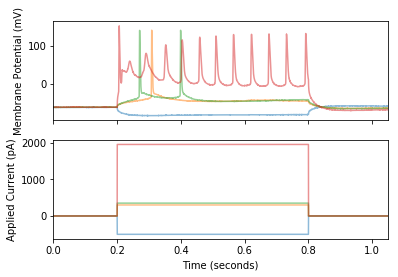

INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


<Figure size 576x360 with 0 Axes>

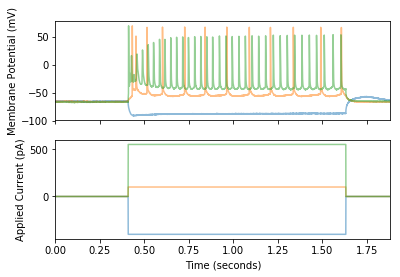

In [66]:

abf_file_name = '15o08011.abf'

#plot_ephys_from_abf(abf_file_name, cell_final_raw_meta_df)
(sweep_set, start_time, end_time) = cell_id_to_sweep_set(abf_file_name, meta_info_df = cell_final_raw_meta_df)
lsa_results = get_lsa_results(sweep_set, start_time, end_time)


rheo_sweep_index = lsa_results['rheobase_sweep'].name
hero_sweep_index = lsa_results['hero_sweep'].name
num_sweeps = len(lsa_results['sweeps'])

show_sweeps = [0, hero_sweep_index, num_sweeps-1]

(fig, ax1, ax2) = plot_ephys_from_abf(abf_file_name, cell_final_raw_meta_df, show_sweeps)

#14617300.abf - FS interneuron
#15616008.abf

INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


Text(0, 0.5, 'firing rate (spikes/s)')

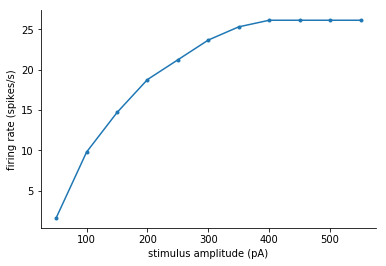

In [67]:
lsa_results = get_lsa_results(sweep_set, start_time, end_time)
#print(lsa_results)

import seaborn as sns
spiking_df = lsa_results["spiking_sweeps"]

plt.plot(spiking_df["stim_amp"], spiking_df["avg_rate"], '.-')
sns.despine()
plt.xlabel("stimulus amplitude (pA)")
plt.ylabel("firing rate (spikes/s)")
#plt.xlim(-300, stim_amps[-1] + 5)

In [47]:
import warnings
warnings.filterwarnings('ignore')
from ipfx.error import FeatureError

use_meta_df = cell_final_raw_meta_df.query('valid_stim == True')
for abf_file_name in use_meta_df.cell_id:
    (sweep_set, start_time, end_time) = cell_id_to_sweep_set(abf_file_name, meta_info_df = cell_final_raw_meta_df)
    try:
        lsa_results = get_lsa_results(sweep_set, start_time, end_time)
    except FeatureError:
        print(abf_file_name)
        print('failing...')
        continue
    

13n05011.abf
13n21007.abf
13d02049.abf
13d02022.abf
13d02004.abf
13d03040.abf
13d03029.abf
13d03008.abf
13d03007.abf
13d03005.abf
20131211_600_1_0066.abf
1000
20131211_600_1_0042.abf
1000
20131211_600_1_0002.abf
1000
20131211_600_1_0081.abf
1000
20131211_600_1_0108.abf
1000
20131211_600_1_0160.abf
1000
20131211_600_1_0067.abf
1000
20131211_600_1_0184.abf
1000
20131211_600_1_0190.abf
1000
20140127_600_1_0158.abf
1000
20140127_600_1_0118.abf
1000
14304311.abf
14304300.abf
14317348.abf
14317320.abf
14317300.abf
14318308.abf
14424329.abf
14424000.abf
14424335.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


14515300.abf
14515374.abf
14515372.abf
14515349.abf
14520332.abf
14520300.abf
14605374.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


14605349.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


14605338.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


14605325.abf
14605321.abf
14605300.abf
14617312.abf
14617300.abf
14624311.abf
14624325.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


14624371.abf
14624300.abf
14624359.abf
14626311.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


14626300.abf
14715300.abf
14715312.abf
14715334.abf
14911303.abf
14911315.abf
14918300.abf
14918302.abf
14918344.abf
14918372.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


14n03302.abf
14n03328.abf
14n04346.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermi

14n04322.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


14n04362.abf
14n10459.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


14n10302.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


14d02000.abf
14d02055.abf
14d02065.abf
14d02124.abf
14d16000.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


14d16016.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


14d16022.abf
14d16056.abf
14d16134.abf
14d18087.abf
14d18113.abf
14d18005.abf
14d18033.abf
15105107.abf
15105065.abf
15105000.abf
15105080.abf
15127132.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)


15127001.abf
failing...
15127028.abf
15127041.abf
15127061.abf
15127092.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
I

15127106.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


15224000.abf
15224059.abf
15302001.abf
15312105.abf
15312053.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


15312031.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


15312132.abf
15312000.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


15330053.abf
15330000.abf
15407000.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


15420026.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


15420000.abf
15616035.abf
15616008.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermi

15616022.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
I

15618005.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermi

15622024.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate

15622019.abf
failing...
15622013.abf
15622005.abf
15622000.abf
15622015.abf
15723013.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


15820003.abf
15o08007.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


15o08011.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


15o08017.abf
15o08002.abf
15o08020.abf
15o08022.abf
15o08032.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


15o08038.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


2015_11_09_0106.abf
2015_11_09_0107.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)


2015_11_09_0003.abf
2015_11_09_0017.abf
2015_11_09_0053.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)


2015_11_09_0085.abf
2015_11_09_0078.abf
2016_01_28_0012.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)


2016_01_28_0019.abf
2016_01_28_0004.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


2016_02_04_0018.abf
2016_02_04_0009.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


2016_02_04_0015.abf
2016_02_04_0021.abf
2016_02_04_0029.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermi

2016_02_04_0033.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


2016_02_04_0042.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
I

2016_02_04_0045.abf
2016_02_25_0255.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)


2016_02_25_0134.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


2016_02_25_0005.abf
2016_02_25_0007.abf
2016_02_25_0073.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


2016_02_25_0082.abf
2016_02_29_0065.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


2016_02_29_0032.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)


2016_03_01_0047.abf
2016_03_01_0000.abf
2016_03_03_0054.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


2016_03_03_0100.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


2016_03_03_0103.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


2016_03_03_0002.abf
2019_11_04_0113.abf
2019_11_26_0094.abf
2019_11_26_0110.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)


2019_11_26_0006.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


2019_11_28_0093.abf
2019_11_28_0079.abf
2019_11_28_0119.abf
2020_01_06_0095.abf
2020_01_06_0090.abf
2020_01_06_0082.abf
2020_01_06_0063.abf
2020_01_06_0048.abf
2020_01_06_0017.abf
2020_01_27_0002.abf
2020_01_27_0008.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


2020_01_27_0042.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)


2020_01_27_0038.abf
2020_01_28_0008.abf
2020_01_28_0017.abf


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


2020_01_28_0029.abf
2020_03_02_0023.abf


In [13]:
lsa_results.keys()

dict_keys(['spikes_set', 'sweeps', 'v_baseline', 'rheobase_i', 'rheobase_sweep', 'spiking_sweeps', 'fi_fit_slope', 'hero_sweep', 'sag', 'vm_for_sag', 'subthreshold_sweeps', 'subthreshold_membrane_property_sweeps', 'input_resistance', 'tau'])

In [19]:
hero_sweep_ind = lsa_results['input_resistance'].name

AttributeError: 'numpy.float64' object has no attribute 'name'

In [15]:
hero_sweep_ind

17

In [21]:
lsa_results['v_baseline']

-60.368126983642576

<Figure size 576x360 with 0 Axes>

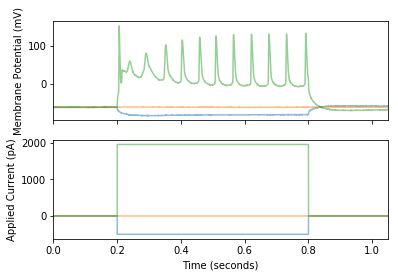

In [39]:
import warnings

abf_file_name = '15622024.abf'
warnings.filterwarnings('ignore')
p1 = plot_ephys_from_abf(abf_file_name, cell_final_raw_meta_df)


Text(0, 0.5, 'firing rate (spikes/s)')

<Figure size 432x288 with 0 Axes>

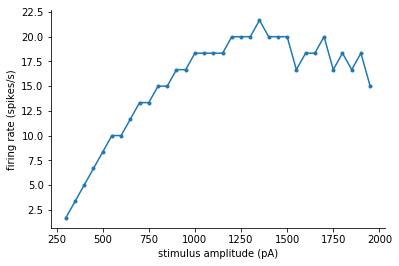

In [46]:
plt.figure(2)
p1
plt.figure(3)
plt.plot(spiking_df["stim_amp"], spiking_df["avg_rate"], '.-')
sns.despine()
plt.xlabel("stimulus amplitude (pA)")
plt.ylabel("firing rate (spikes/s)")

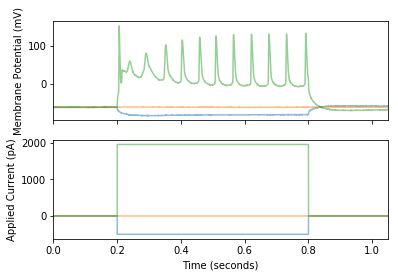

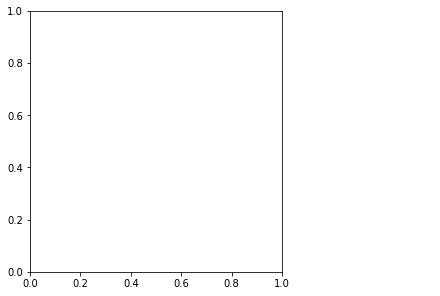

In [50]:
fig5 = plt.figure(constrained_layout=True)
widths = [2, 3, 1.5]
heights = [1, 3, 2]
spec5 = fig5.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])
ax = fig5.add_subplot(spec5[0, 0])
p1
# ax = fig5.add_subplot(spec5[0, 1])
# plt.plot(spiking_df["stim_amp"], spiking_df["avg_rate"], '.-')
# sns.despine()
# plt.xlabel("stimulus amplitude (pA)")
# plt.ylabel("firing rate (spikes/s)")